# Schedtune.prefer_idle experiment

This notebook demonstrates the workload behaviour for different schedtune.prefer_idle setting

In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)
# Comment the follwing line to disable devlib debugging statements
# logging.getLogger('ssh').setLevel(logging.DEBUG)

In [2]:
# Generate plots inline
%pylab inline

import json
import os
import subprocess

# Support to access the remote target
import devlib
from env import TestEnv

# Support for trace events analysis
from trace import Trace

# Support to configure and run RTApp based workloads
from wlgen import RTA

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


# Test environment setup

In [3]:
# Setup a target configuration
my_target_conf = {
    
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/home/lisa/android-sdk",
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },

    # Define devlib module to load
    #"modules"     : [
    #    'bl',           # enable big.LITTLE support
    #    'cpufreq'       # enable CPUFreq support
    #],

    # Account to access the remote target
    "host"        : '10.169.36.25',
    "username"    : 'root',
    "password"    : '',

    # Comment the following line to force rt-app calibration on your target

}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
            "cpu_frequency",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_switch",
            'dequeue_task_fair', 
            'enqueue_task_fair', 
            'set_next_entity',

                    
            "cpu_capacity",
            "cpu_idle",
            
            #/sys/kernel/debug/tracing/events/sched
            "sched_blocked_reason",
            "sched_boost_cpu",
            "sched_boost_task",
            "sched_contrib_scale_f",
            "sched_cpu_hotplug",
            "sched_energy_diff",
            "sched_kthread_stop",
            "sched_kthread_stop_ret",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_migrate_task",
            "sched_move_numa",
            "sched_pi_setprio",
            "sched_process_exec",
            "sched_process_exit",
            "sched_process_fork",
            "sched_process_free",
            "sched_process_wait",
            "sched_stat_blocked",
            "sched_stat_iowait",
            "sched_stat_runtime",
            "sched_stat_sleep",
            "sched_stat_wait",
            "sched_stick_numa",
            "sched_swap_numa",
            "sched_switch",
            "sched_tune_boostgroup_update",
            "sched_tune_config",
            "sched_tune_tasks_update",
            "sched_tune_filter",
            "sched_wait_task",
            "sched_wake_idle_without_ipi",
            "sched_wakeup",
            "sched_wakeup_new",
            
            
         ],
         "buffsize" : 10240
    },
    "results_dir" : "prefer_idle",
}

In [4]:
# Support to access the remote target
import devlib
from env import TestEnv

# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

02:06:11  INFO    : Using base path: /home/lisa/lisa-github
02:06:11  INFO    : Loading custom (inline) target configuration
02:06:11  INFO    : Loading custom (inline) test configuration
02:06:11  WARNING : Wipe previous contents of the results folder:
02:06:11  WARNING :    /home/lisa/lisa-github/results/prefer_idle
02:06:11  INFO    : External tools using:
02:06:11  INFO    :    ANDROID_HOME: /home/lisa/android-sdk
02:06:11  INFO    :    CATAPULT_HOME: /home/lisa/lisa-github/tools/catapult
02:06:11  INFO    : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
02:06:11  INFO    : Connecting Android target [0123456789ABCDEF]
02:06:11  INFO    : Connection settings:
02:06:11  INFO    :    {'device': '0123456789ABCDEF'}
02:06:12  INFO    : Initializing target workdir:
02:06:12  INFO    :    /data/local/tmp/devlib-target
02:06:15  INFO    : Attempting to read energy model from target
02:06:17  INFO    : Topology:
02:06:17  INFO    :    [[0, 1, 2, 3], [4, 5, 6, 7]]
02:06:17  INFO    : L

# Workload configuration

In [5]:
# Support to configure and run RTApp based workloads
from wlgen import RTA, Periodic, Ramp

# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
    # 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={
        
        "period_1" : Periodic(
            period_ms=100,
            duty_cycle_pct=10,
            duration_s=10,
        ).get(),

        "period_2" : Periodic(
            period_ms=100,
            duty_cycle_pct=50,
            duration_s=10,
        ).get(),
        
        "period_3" : Periodic(
            period_ms=100,
            duty_cycle_pct=10,
            duration_s=10,
        ).get(),
        
         "period_4" : Periodic(
            period_ms=100,
            duty_cycle_pct=50,
            duration_s=10,
        ).get(),

                
        "ramp_1" : Ramp(
            start_pct=5,           # intial load
            end_pct=85,            # end load
            delta_pct=20,          # load % increase...
            time_s=1,              # ... every 1 second            
        ).get(),

        "ramp_2" : Ramp(
            start_pct=10,          # intial load
            end_pct=60,            # end load
            delta_pct=5,           # load % increase...
            time_s=1,              # ... every 1 second            
        ).get(),

    },
    
    # 4. use this folder for task logfiles
    run_dir=target.working_directory
    
);

02:06:18  INFO    : Setup new workload simple
02:06:18  INFO    : Workload duration defined by longest task
02:06:18  INFO    : Default policy: SCHED_OTHER
02:06:18  INFO    : ------------------------
02:06:18  INFO    : task [period_1], sched: using default policy
02:06:18  INFO    :  | loops count: 1
02:06:18  INFO    : + phase_000001: duration 10.000000 [s] (100 loops)
02:06:18  INFO    : |  period   100000 [us], duty_cycle  10 %
02:06:18  INFO    : |  run_time  10000 [us], sleep_time  90000 [us]
02:06:18  INFO    : ------------------------
02:06:18  INFO    : task [period_2], sched: using default policy
02:06:18  INFO    :  | loops count: 1
02:06:18  INFO    : + phase_000001: duration 10.000000 [s] (100 loops)
02:06:18  INFO    : |  period   100000 [us], duty_cycle  50 %
02:06:18  INFO    : |  run_time  50000 [us], sleep_time  50000 [us]
02:06:18  INFO    : ------------------------
02:06:18  INFO    : task [period_3], sched: using default policy
02:06:18  INFO    :  | loops count: 

# Workload execution

In [6]:
# Set Sched governor
#
# For Juno big/LITTLE CPUs
#
logging.info("Target ABI: %s, CPus: %s",
             target.abi,
             target.cpuinfo.cpu_names)

target.cpufreq.set_all_governors('sched')

logging.info("Target current governor: %s",
             target.read_value("/sys/devices/system/cpu/cpu0/cpufreq/scaling_governor")
            )
logging.info("Target big CPU max CPUfreq:%s\n\t\t    Target big CPU current CPUfreq: %s", 
             target.read_value("/sys/devices/system/cpu/cpu4/cpufreq/scaling_max_freq"),
             target.read_value("/sys/devices/system/cpu/cpu4/cpufreq/scaling_cur_freq")
             )

logging.info("Target LITTLE CPU max CPUfreq:%s \n\t\t    Target LITTLE CPU current CPUfreq: %s", 
             target.read_value("/sys/devices/system/cpu/cpu0/cpufreq/scaling_max_freq"),
             target.read_value("/sys/devices/system/cpu/cpu0/cpufreq/scaling_cur_freq")
             )

02:06:18  INFO    : Target ABI: arm64, CPus: ['A53', 'A53', 'A53', 'A53', 'A73', 'A73', 'A73', 'A73']
02:06:19  INFO    : Target current governor: sched
02:06:19  INFO    : Target big CPU max CPUfreq:2362000
		    Target big CPU current CPUfreq: 903000
02:06:19  INFO    : Target LITTLE CPU max CPUfreq:1200000 
		    Target LITTLE CPU current CPUfreq: 999000


# schedtune.prefer_idle = 0

In [7]:
#
# configure prefer_idle
#
logging.info("/dev/stune/schedtune.prefer_idle = %s",  target.read_value("/dev/stune/schedtune.prefer_idle"))
#os.system("uname -a")
#target.execute("ls -al /dev/stune")
target.execute("echo 0 > /dev/stune/schedtune.prefer_idle")
logging.info("/dev/stune/schedtune.prefer_idle = %s",  target.read_value("/dev/stune/schedtune.prefer_idle"))

02:06:19  INFO    : /dev/stune/schedtune.prefer_idle = 1
02:06:19  INFO    : /dev/stune/schedtune.prefer_idle = 0


In [8]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

02:06:19  INFO    : #### Setup FTrace
02:06:21  INFO    : #### Start energy sampling


02:06:22  INFO    : #### Start RTApp execution
02:06:22  INFO    : Workload execution START:
02:06:22  INFO    :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1
02:06:34  INFO    : #### Read energy consumption: /home/lisa/lisa-github/results/prefer_idle/energy.json
02:06:34  ERROR   : /usr/bin/iio-capture terminated for Device1 (iio:device1)
02:06:34  ERROR   : [Unable to create IIO context
]
02:06:34  ERROR   : /usr/bin/iio-capture terminated for Device0 (iio:device0)
02:06:34  ERROR   : [Unable to create IIO context
]
02:06:34  INFO    : #### Stop FTrace
02:06:35  INFO    : #### Save FTrace: /home/lisa/lisa-github/results/prefer_idle/trace.dat
02:06:36  INFO    : #### Save platform description: /home/lisa/lisa-github/results/prefer_idle/platform.json


# Collected results

In [9]:
# All data are produced in the output folder defined by the TestEnv module
logging.info('Content of the output folder %s', te.res_dir)
!ls -la {te.res_dir}

02:06:36  INFO    : Content of the output folder /home/lisa/lisa-github/results/prefer_idle


total 11148
drwxrwxr-x 1 lisa lisa      506 Sep  8 02:06 .
drwxrwxr-x 1 lisa lisa     1110 Sep  8 02:06 ..
-rw-rw-r-- 1 lisa lisa        2 Sep  8 02:06 energy.json
-rw-rw-r-- 1 lisa lisa        2 Sep  8 02:06 energy_stats.json
-rw-rw-r-- 1 lisa lisa      855 Sep  8 02:06 output.log
-rw-rw-r-- 1 lisa lisa     1518 Sep  8 02:06 platform.json
-rw-r--r-- 1 lisa lisa    12560 Sep  8 02:06 rt-app-period_1-0.log
-rw-r--r-- 1 lisa lisa    12560 Sep  8 02:06 rt-app-period_2-1.log
-rw-r--r-- 1 lisa lisa    12560 Sep  8 02:06 rt-app-period_3-2.log
-rw-r--r-- 1 lisa lisa    12560 Sep  8 02:06 rt-app-period_4-3.log
-rw-r--r-- 1 lisa lisa     6360 Sep  8 02:06 rt-app-ramp_1-0.log
-rw-r--r-- 1 lisa lisa     6360 Sep  8 02:06 rt-app-ramp_1-2.log
-rw-r--r-- 1 lisa lisa     6360 Sep  8 02:06 rt-app-ramp_1-4.log
-rw-r--r-- 1 lisa lisa    13800 Sep  8 02:06 rt-app-ramp_2-3.log
-rw-r--r-- 1 lisa lisa    13800 Sep  8 02:06 rt-app-ramp_2-5.log
-rw-r--r-- 1 lisa lisa     5956 Sep  8 02:06 simple_00.json
-rw-r

In [10]:
# Inspect the JSON file used to run the application
with open('{}/simple_00.json'.format(te.res_dir), 'r') as fh:
    rtapp_json = json.load(fh, )
logging.info('Generated RTApp JSON file:')
#print json.dumps(rtapp_json, indent=4, sort_keys=True)

02:06:37  INFO    : Generated RTApp JSON file:


In [11]:
# Dump the energy measured for the LITTLE and big clusters
logging.info('Energy: %s', nrg_report.report_file)
print json.dumps(nrg_report.channels , indent=4, sort_keys=True)

02:06:37  INFO    : Energy: /home/lisa/lisa-github/results/prefer_idle/energy.json


{}


In [12]:
# Dump the platform descriptor, which could be useful for further analysis
# of the generated results
logging.info('Platform description: %s', plt_file)
#print json.dumps(plt, indent=4, sort_keys=True)

02:06:37  INFO    : Platform description: /home/lisa/lisa-github/results/prefer_idle/platform.json


# Trace inspection

In [13]:
# Suport for FTrace events parsing and visualization
import trappy

# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

# Task Behavior

In [14]:
events_to_parse = my_tests_conf['ftrace']['events']

trace = Trace(plt, te.res_dir, events_to_parse)

ftrace = trace.ftrace

trappy.plotter.plot_trace(ftrace, execnames=['period_1', "period_2", "period_3","period_4",
                                             "ramp_1", "ramp_2",                                             ])

/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.set_next_entity object at 0x7f9a28e46f50> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f9a28b760d0> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_move_numa object at 0x7f9a28b761d0> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_wait_task object at 0x7f9a28b762d0> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_stat_blocked object at 0x7f9a28b764d0> from c

# Analysis

02:07:06  INFO    : ftrace object =<trappy.ftrace.FTrace object at 0x7f9a28e46090>


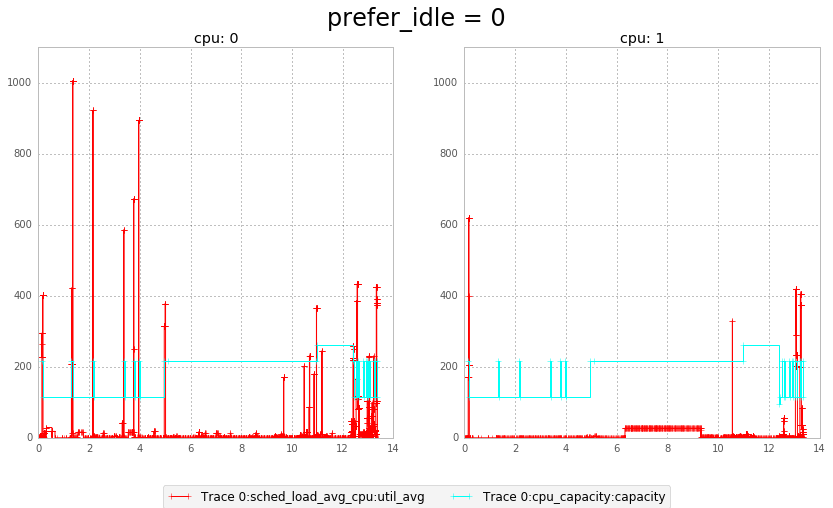

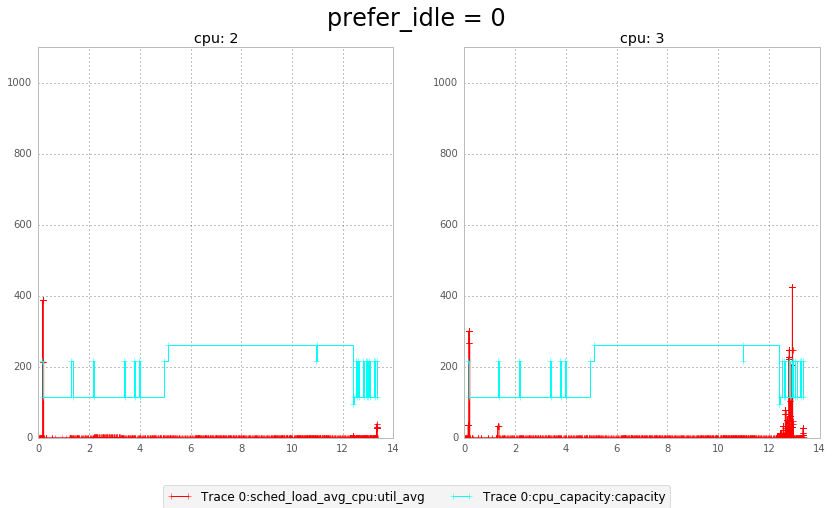

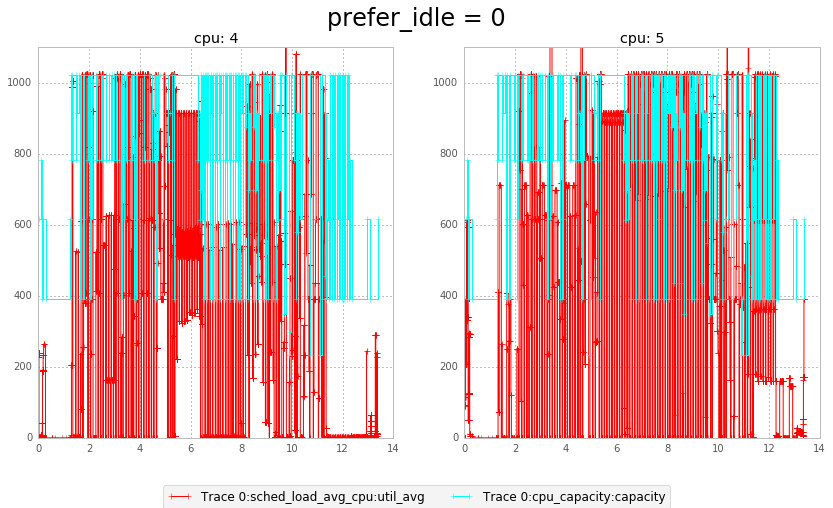

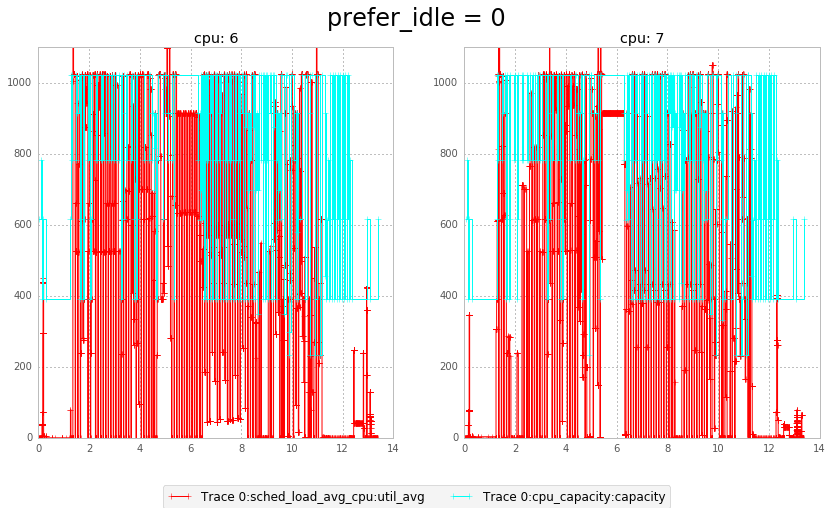

In [15]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
logging.info("ftrace object =%s", ftrace)
#trappy.ftrace.plotClusterFrequencies()


trappy.LinePlot(ftrace,
    signals=[
    "sched_load_avg_cpu:util_avg",
    "cpu_capacity:capacity"],
    pivot="cpu",
    filters={"cpu": [0,1]},
    marker = '+',
    drawstyle='steps-post',
    title="prefer_idle = 0",
    ylim=(0, 1100)).view()
trappy.LinePlot(ftrace,
    signals=[
    "sched_load_avg_cpu:util_avg",
    "cpu_capacity:capacity"],
    pivot="cpu",
    filters={"cpu": [2,3]},
    marker = '+',
    drawstyle='steps-post',
    title="prefer_idle = 0",
    ylim=(0, 1100)).view()
trappy.LinePlot(ftrace,
    signals=[
    "sched_load_avg_cpu:util_avg",
    "cpu_capacity:capacity"],
    pivot="cpu",
    filters={"cpu": [4,5]},
    marker = '+',
    drawstyle='steps-post',
    title="prefer_idle = 0",
    ylim=(0, 1100)).view()
trappy.LinePlot(ftrace,
    signals=[
    "sched_load_avg_cpu:util_avg",
    "cpu_capacity:capacity"],
    pivot="cpu",
    filters={"cpu": [6,7]},
    marker = '+',
    drawstyle='steps-post',
    title="prefer_idle = 0",
    ylim=(0, 1100)).view()

02:07:09  WARNING : Event [sched_overutilized] not found, plot DISABLED!
02:07:09  WARNING : Event [sched_overutilized] not found, plot DISABLED!
02:07:09  INFO    : LITTLE cluster average frequency: 0.565 GHz
02:07:09  INFO    : big    cluster average frequency: 1.883 GHz


(0.56534870695326833, 1.8826872495367923)

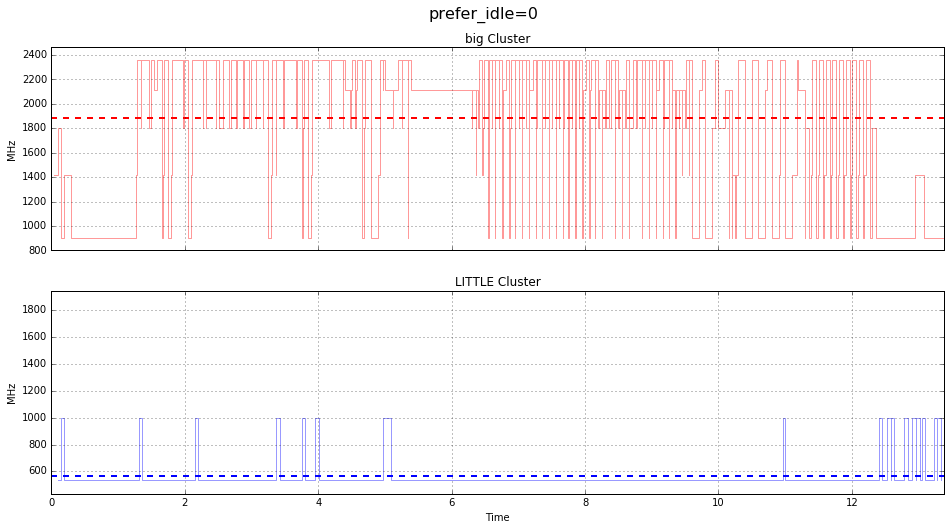

In [16]:
trace.analysis.frequency.plotClusterFrequencies("prefer_idle=0")

In [17]:
trace.data_frame.cpu_idle_state_residency(0)

,time
idle_state,
0,0.921863
1,8.221370
2,3.619803
3,0.000000


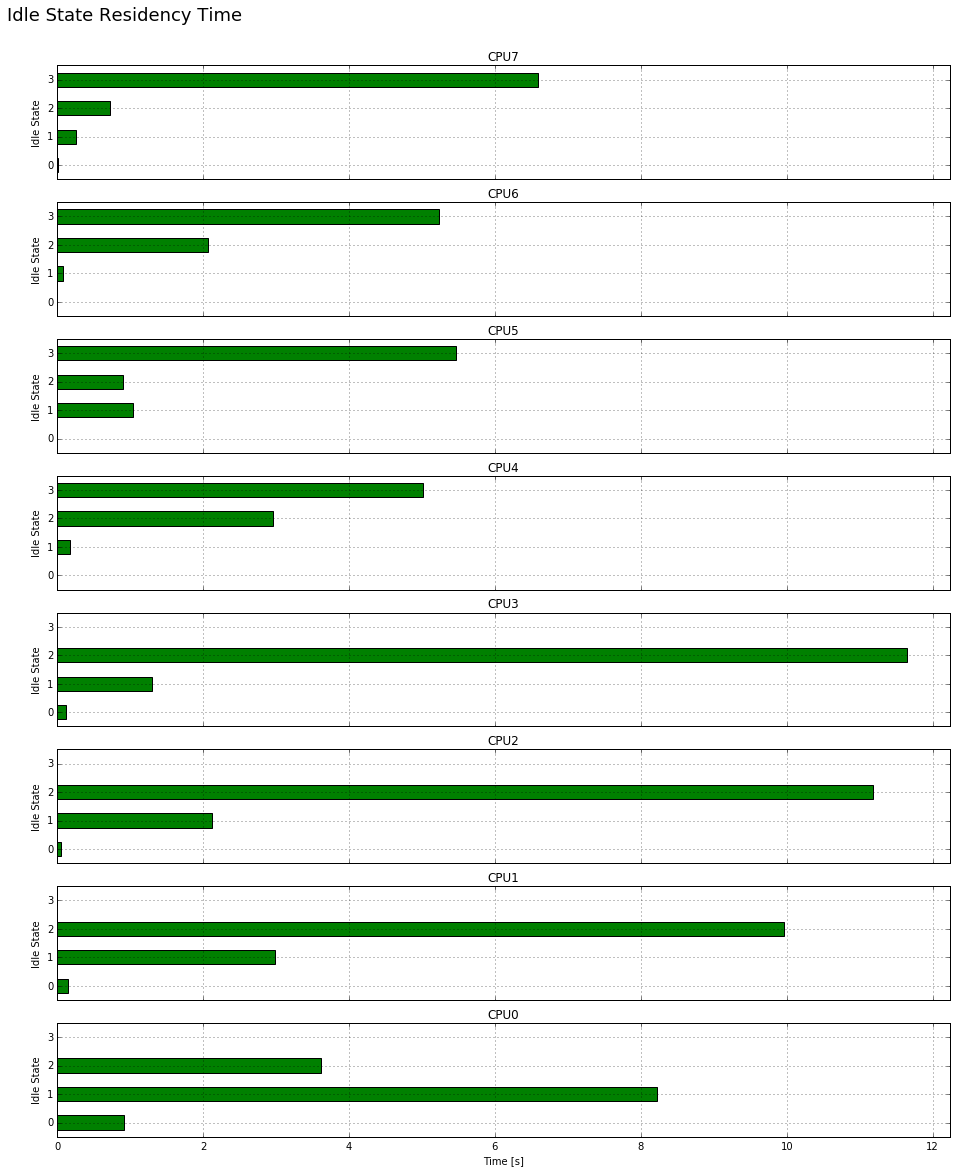

In [18]:
ia = trace.analysis.idle

# Actual time spent in each idle state
ia.plotCPUIdleStateResidency([0, 1,2, 3, 4, 5,6,7])

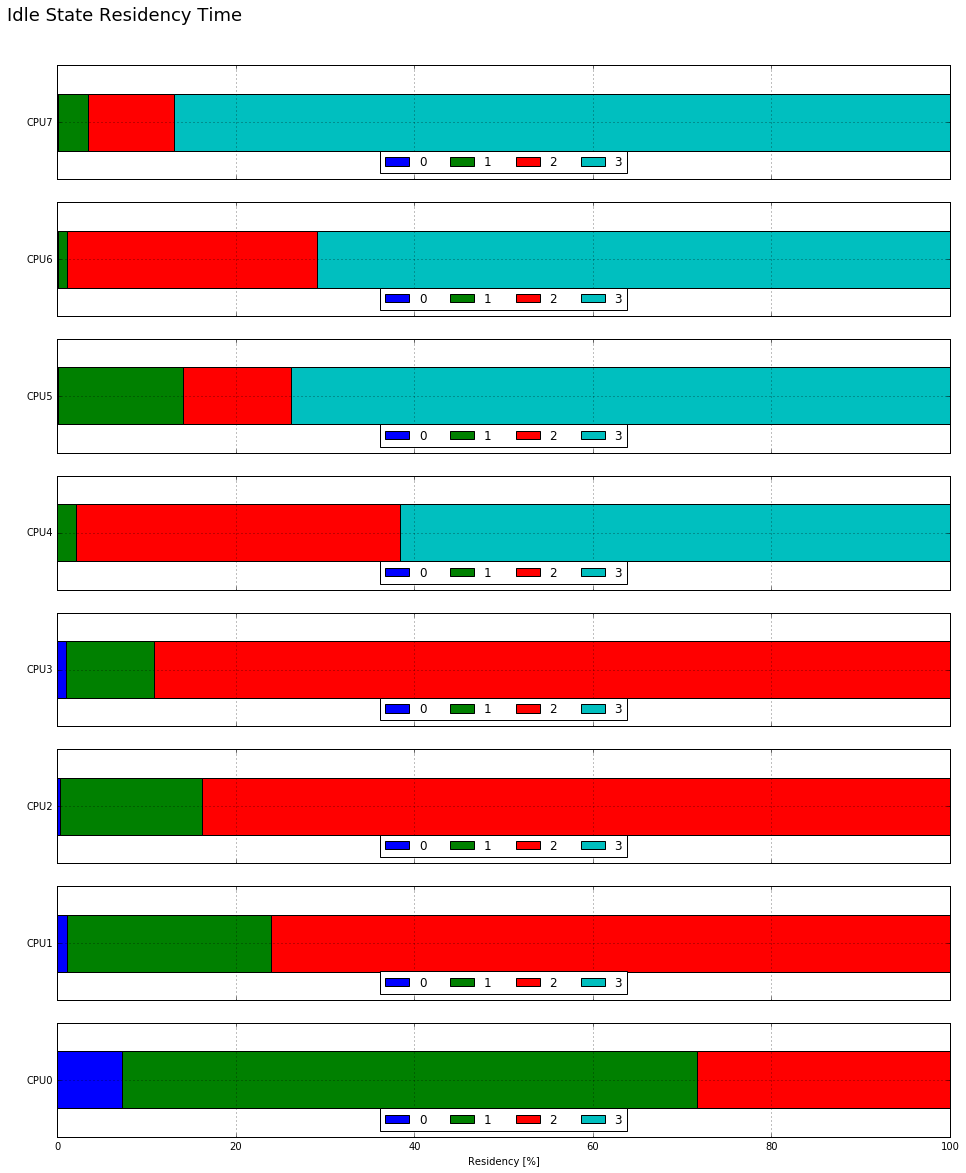

In [19]:
# Percentage of time spent in each idle state
ia.plotCPUIdleStateResidency([0,1,2,3,4,5,6,7], pct=True)

02:07:15  INFO    : PerfIndex, Task [period_2] avg: 0.70, std: 0.34
02:07:16  INFO    : PerfIndex, Task [period_3] avg: 0.90, std: 0.13
02:07:17  INFO    : PerfIndex, Task [ramp_1] avg: 0.58, std: 0.45
02:07:18  INFO    : PerfIndex, Task [period_1] avg: 0.90, std: 0.13
02:07:19  INFO    : PerfIndex, Task [period_4] avg: 0.75, std: 0.33
02:07:21  INFO    : PerfIndex, Task [ramp_2] avg: 0.75, std: 0.27


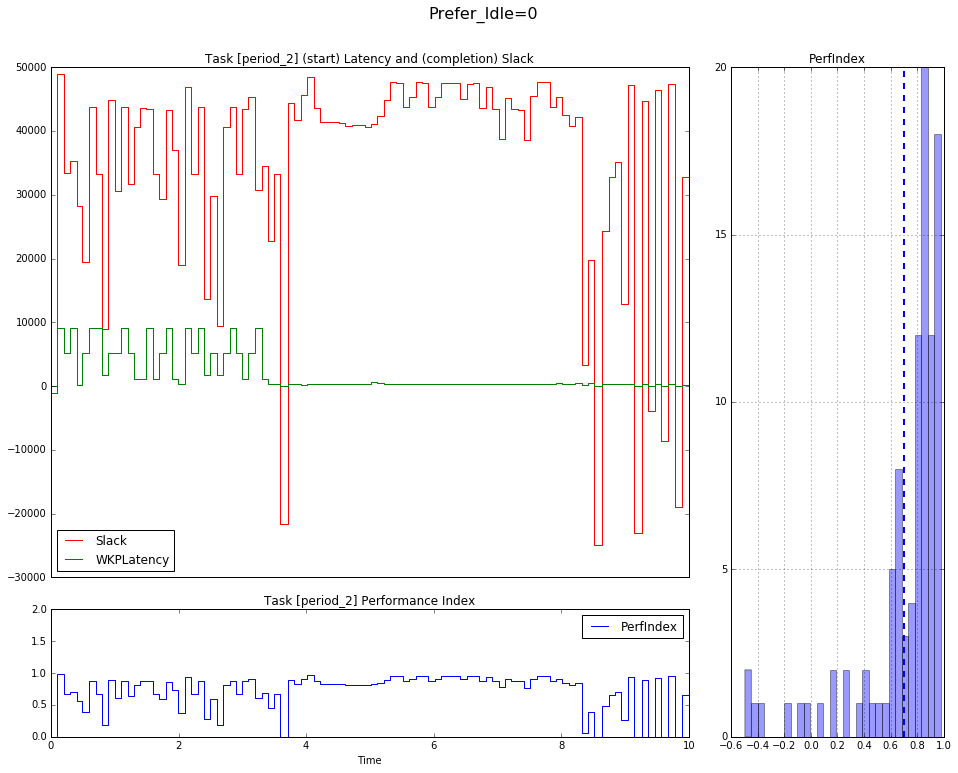

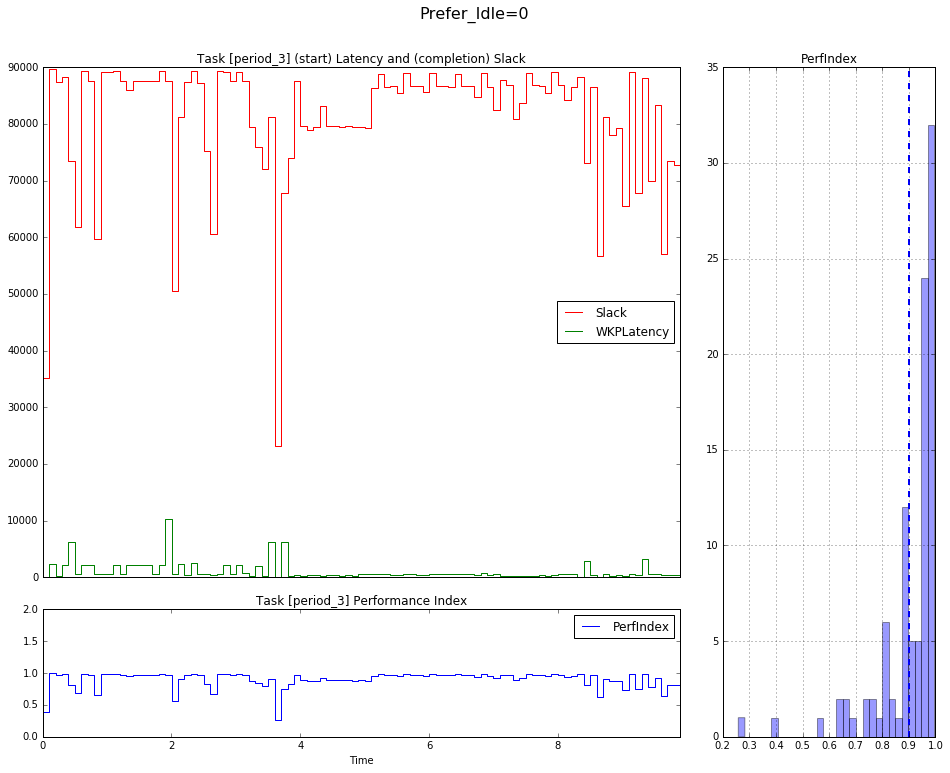

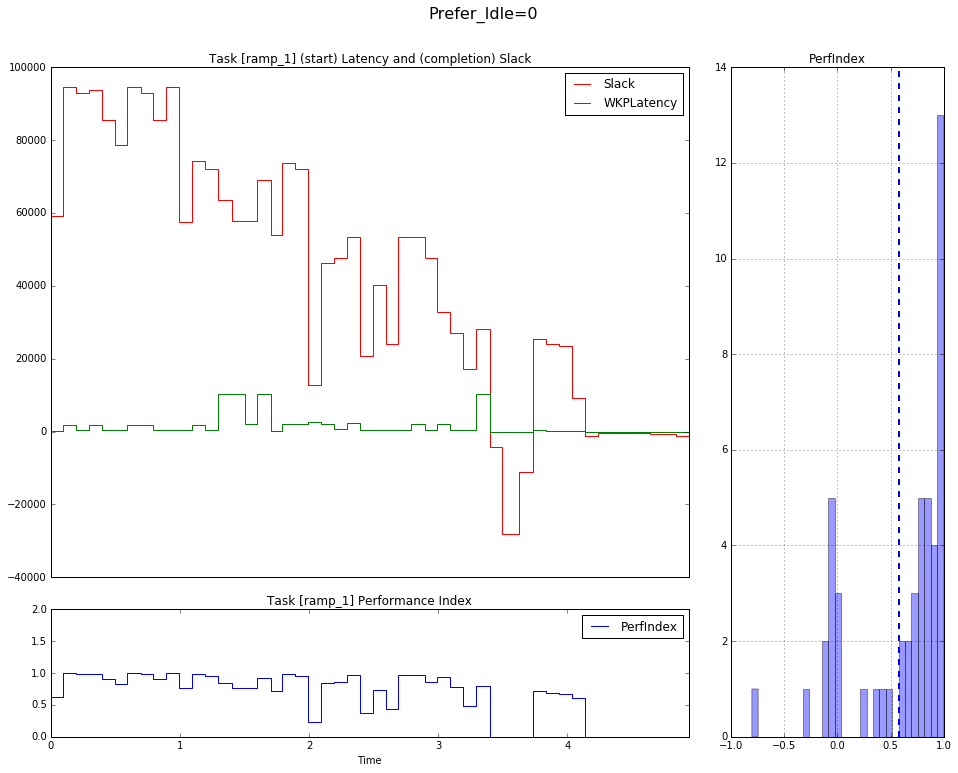

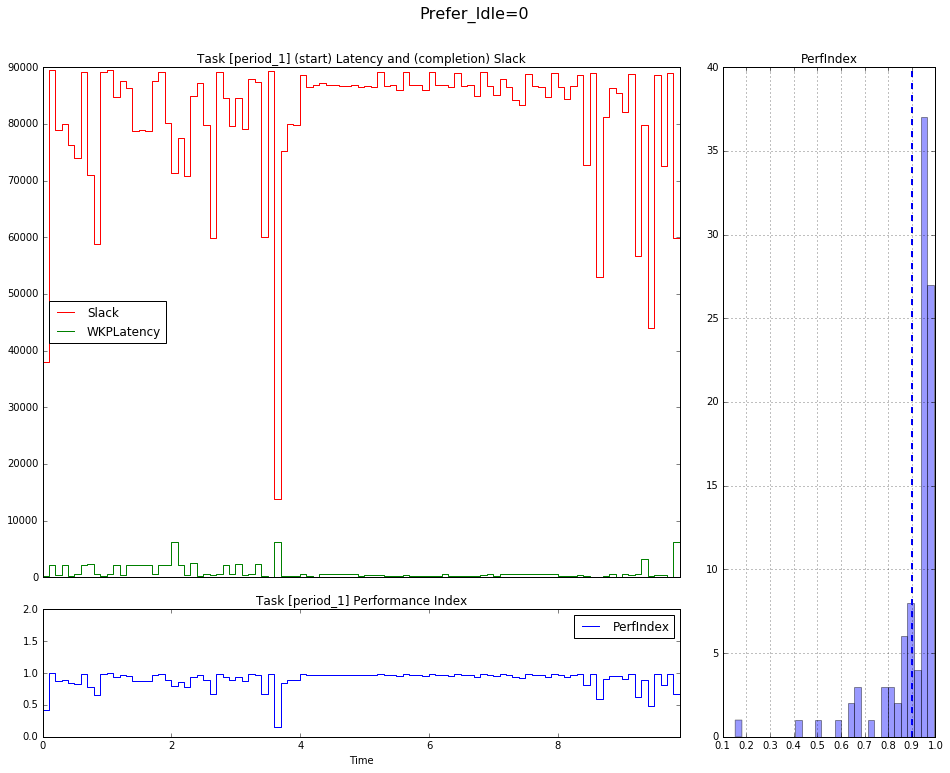

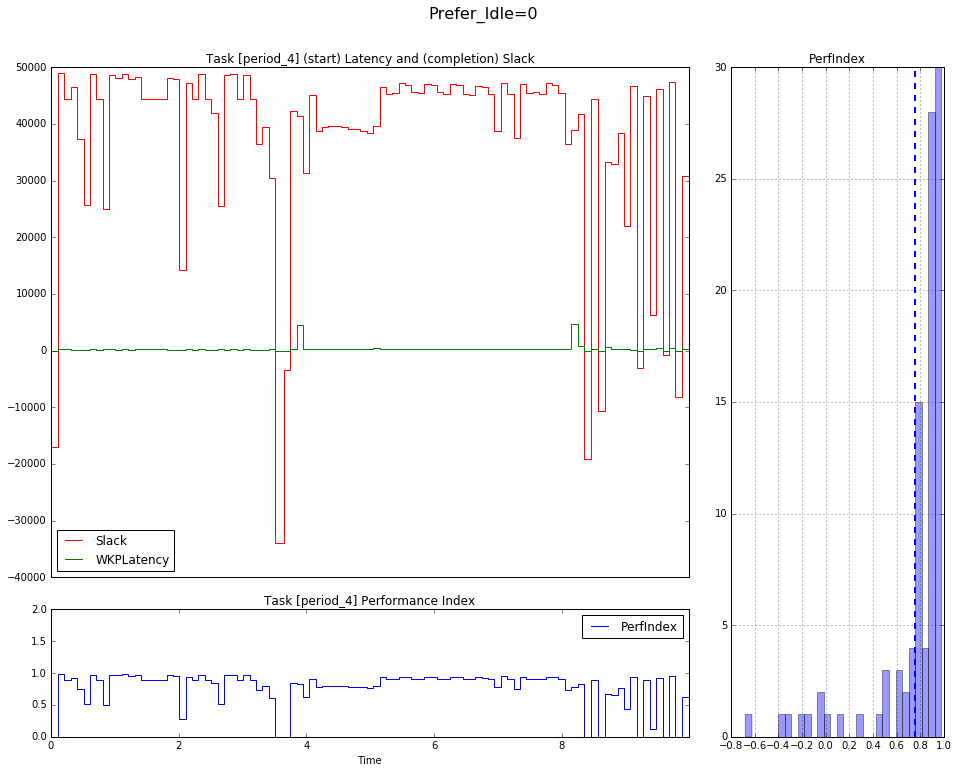

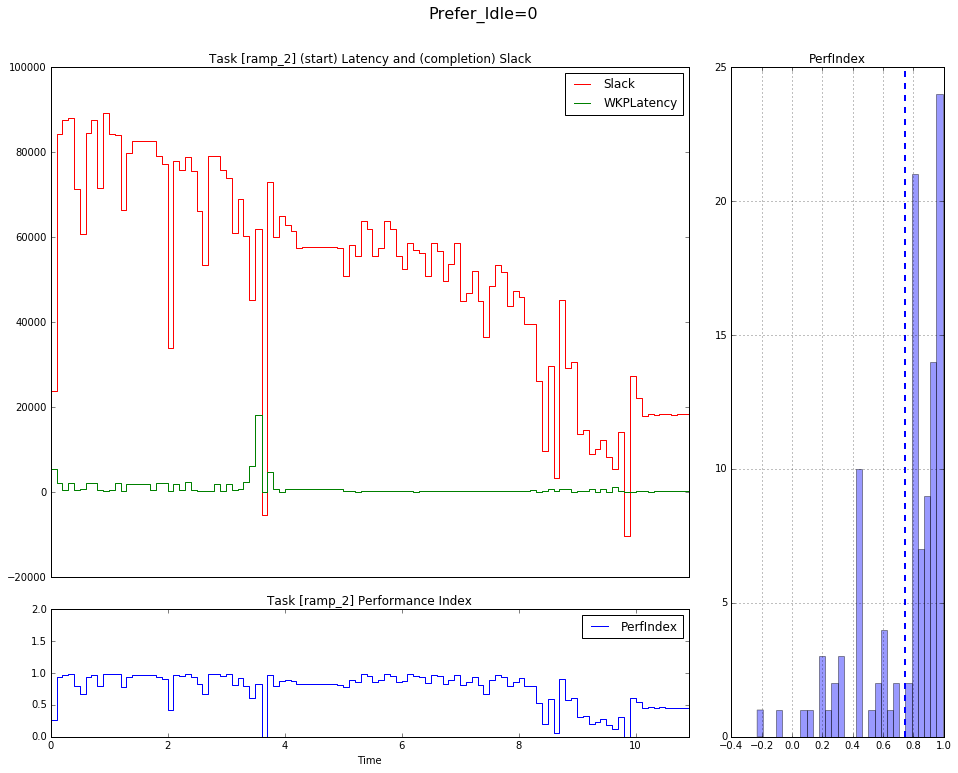

In [20]:
pa = PerfAnalysis( te.res_dir )

for task in pa.tasks():
    pa.plotPerf(task, "Prefer_Idle=0")

# schedtune.prefer_idle = 1

In [21]:
#
# configure prefer_idle
#
logging.info("/dev/stune/schedtune.prefer_idle = %s",  target.read_value("/dev/stune/schedtune.prefer_idle"))
#os.system("uname -a")
#target.execute("ls -al /dev/stune")
target.execute("echo 1 > /dev/stune/schedtune.prefer_idle")
logging.info("/dev/stune/schedtune.prefer_idle = %s",  target.read_value("/dev/stune/schedtune.prefer_idle"))

02:07:24  INFO    : /dev/stune/schedtune.prefer_idle = 0
02:07:24  INFO    : /dev/stune/schedtune.prefer_idle = 1


In [22]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

02:07:24  INFO    : #### Setup FTrace
02:07:27  INFO    : #### Start energy sampling


02:07:28  INFO    : #### Start RTApp execution
02:07:28  INFO    : Workload execution START:
02:07:28  INFO    :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1
02:07:40  INFO    : #### Read energy consumption: /home/lisa/lisa-github/results/prefer_idle/energy.json
02:07:40  ERROR   : /usr/bin/iio-capture terminated for Device1 (iio:device1)
02:07:40  ERROR   : [Unable to create IIO context
]
02:07:40  ERROR   : /usr/bin/iio-capture terminated for Device0 (iio:device0)
02:07:40  ERROR   : [Unable to create IIO context
]
02:07:40  INFO    : #### Stop FTrace
02:07:40  INFO    : #### Save FTrace: /home/lisa/lisa-github/results/prefer_idle/trace.dat
02:07:43  INFO    : #### Save platform description: /home/lisa/lisa-github/results/prefer_idle/platform.json


# Trace Analysis

In [24]:
# Suport for FTrace events parsing and visualization
import trappy

# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

In [25]:
events_to_parse = my_tests_conf['ftrace']['events']

trace2 = Trace(plt, te.res_dir, events_to_parse)

ftrace2 = trace2.ftrace

trappy.plotter.plot_trace(ftrace2, execnames=['period_1', "period_2", "period_3","period_4",
                                             "ramp_1", "ramp_2",                                             ])

/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.set_next_entity object at 0x7f9a29f5bf10> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f9a2973a890> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_move_numa object at 0x7f9a17d99c50> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_wait_task object at 0x7f9a17d99d50> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_stat_blocked object at 0x7f9a17d99110> from c

02:13:53  INFO    : ftrace object =<trappy.ftrace.FTrace object at 0x7f9a2a04ff50>


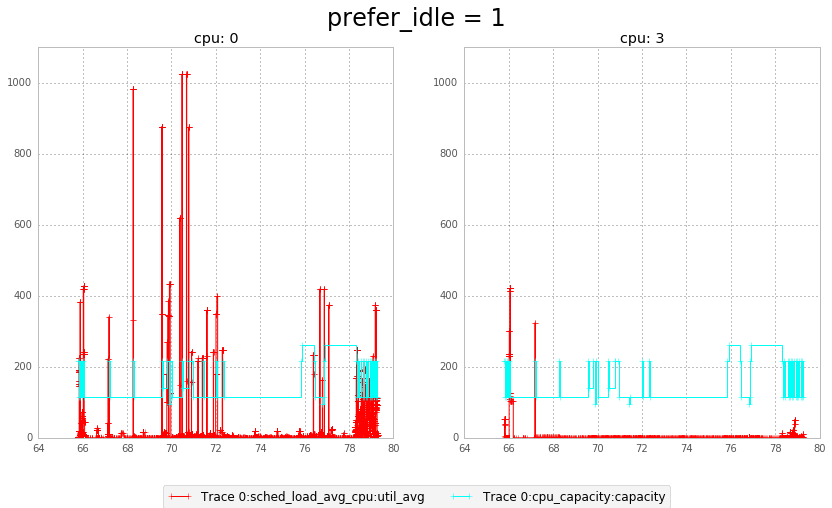

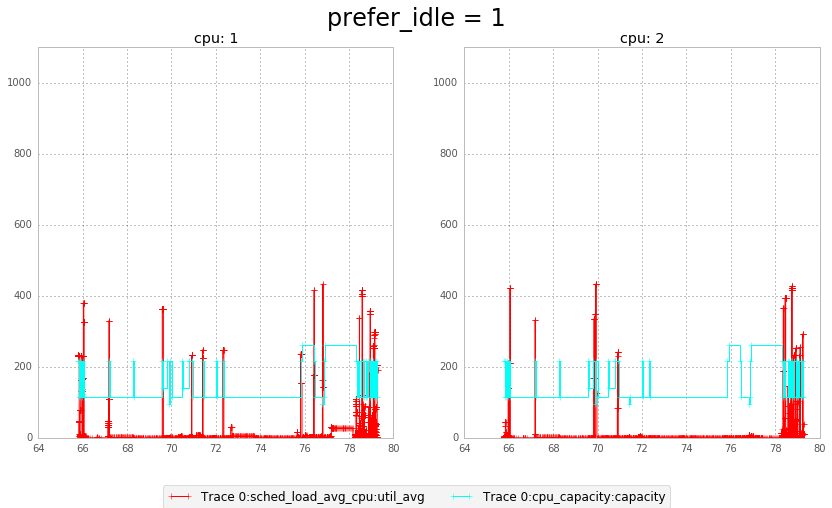

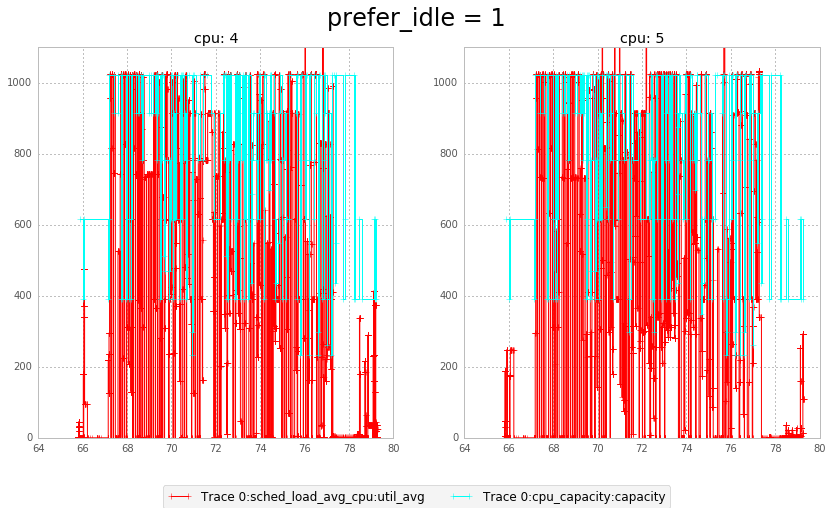

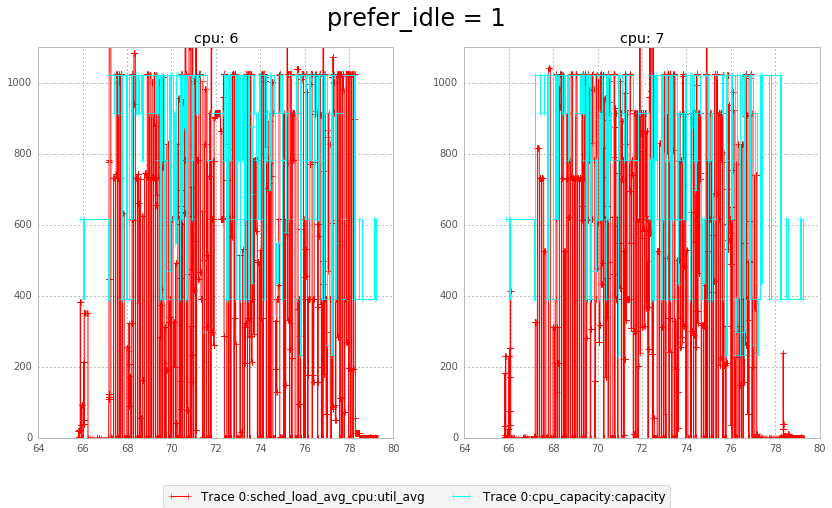

In [32]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
logging.info("ftrace object =%s", ftrace2)
#trappy.ftrace.plotClusterFrequencies()


trappy.LinePlot(ftrace2,
    signals=[
    "sched_load_avg_cpu:util_avg",
    #"sched_load_avg_cpu:load_avg",
    "cpu_capacity:capacity"],
    pivot="cpu",
    filters={"cpu": [0,3]},
    marker = '+',
    drawstyle='steps-post',
    title="prefer_idle = 1",
    ylim=(0, 1100)).view()
trappy.LinePlot(ftrace2,
    signals=[
    "sched_load_avg_cpu:util_avg",
    #"sched_load_avg_cpu:load_avg",
    "cpu_capacity:capacity"],
    pivot="cpu",
    filters={"cpu": [1,2]},
    marker = '+',
    drawstyle='steps-post',
    title="prefer_idle = 1",
    ylim=(0, 1100)).view()
trappy.LinePlot(ftrace2,
    signals=[
    "sched_load_avg_cpu:util_avg",
    #"sched_load_avg_cpu:load_avg",
    "cpu_capacity:capacity"],
    pivot="cpu",
    filters={"cpu": [4,5]},
    marker = '+',
    drawstyle='steps-post',
    title="prefer_idle = 1",
    ylim=(0, 1100)).view()
trappy.LinePlot(ftrace2,
    signals=[
    "sched_load_avg_cpu:util_avg",
    #"sched_load_avg_cpu:load_avg",
    "cpu_capacity:capacity"],
    pivot="cpu",
    filters={"cpu": [6,7]},
    marker = '+',
    drawstyle='steps-post',
    title="prefer_idle = 1",
    ylim=(0, 1100)).view()

02:09:10  WARNING : Event [sched_overutilized] not found, plot DISABLED!
02:09:10  WARNING : Event [sched_overutilized] not found, plot DISABLED!
02:09:10  INFO    : LITTLE cluster average frequency: 0.588 GHz
02:09:10  INFO    : big    cluster average frequency: 1.875 GHz


(0.58838705824347404, 1.8751715101985398)

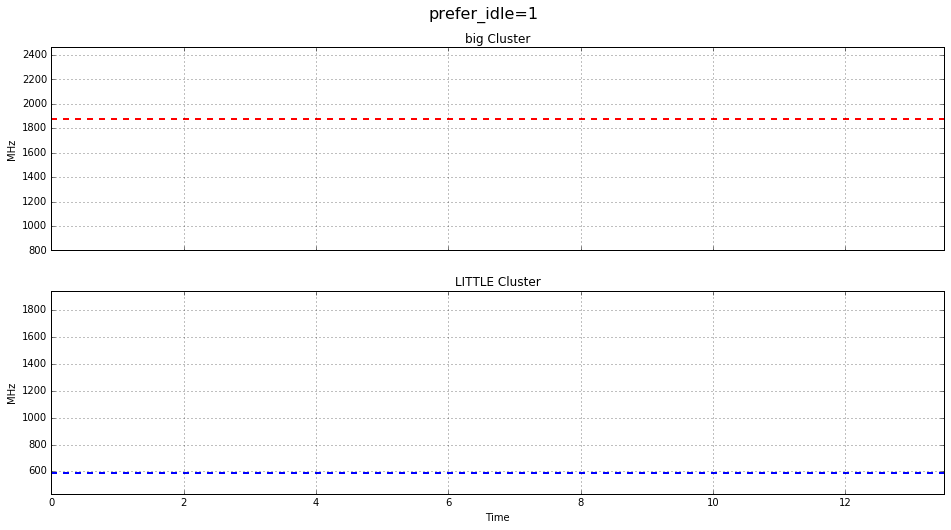

In [27]:
trace2.analysis.frequency.plotClusterFrequencies("prefer_idle=1")


In [35]:
trace2.data_frame.cpu_idle_state_residency(0)

,time
idle_state,
0,0.128304
1,0.212181
2,-52.699258
3,0.000000


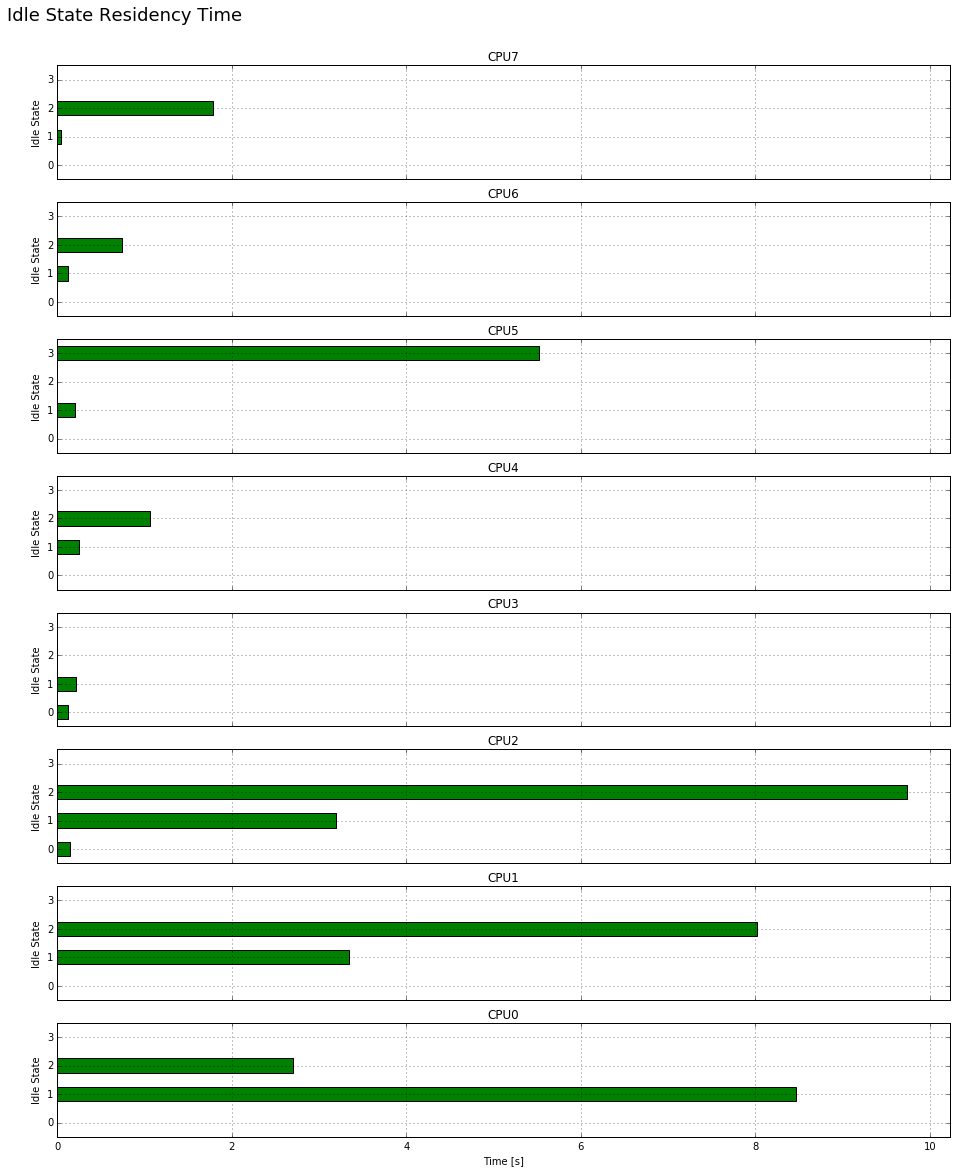

In [29]:
ia_2 = trace2.analysis.idle

# Actual time spent in each idle state
ia_2.plotCPUIdleStateResidency([0, 1,2, 3, 4, 5,6,7])

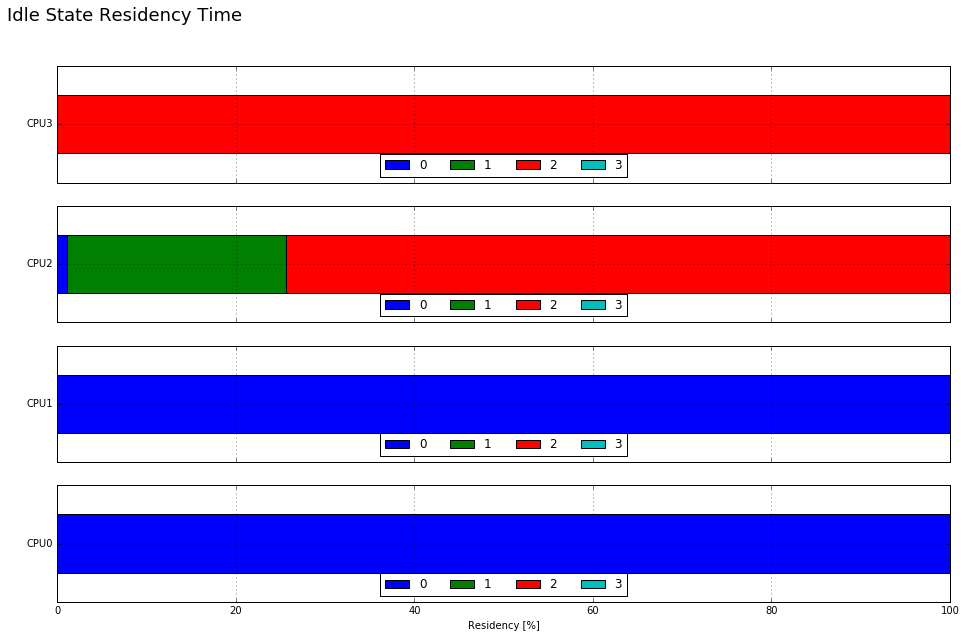

In [30]:
# Percentage of time spent in each idle state
ia_2.plotCPUIdleStateResidency([0,1,2,3], pct=True)

02:09:29  INFO    : PerfIndex, Task [period_2] avg: 0.65, std: 0.34
02:09:31  INFO    : PerfIndex, Task [period_3] avg: 0.87, std: 0.13
02:09:32  INFO    : PerfIndex, Task [ramp_1] avg: 0.34, std: 0.93
02:09:33  INFO    : PerfIndex, Task [period_1] avg: 0.87, std: 0.13
02:09:34  INFO    : PerfIndex, Task [period_4] avg: 0.62, std: 0.35
02:09:35  INFO    : PerfIndex, Task [ramp_2] avg: 0.71, std: 0.34


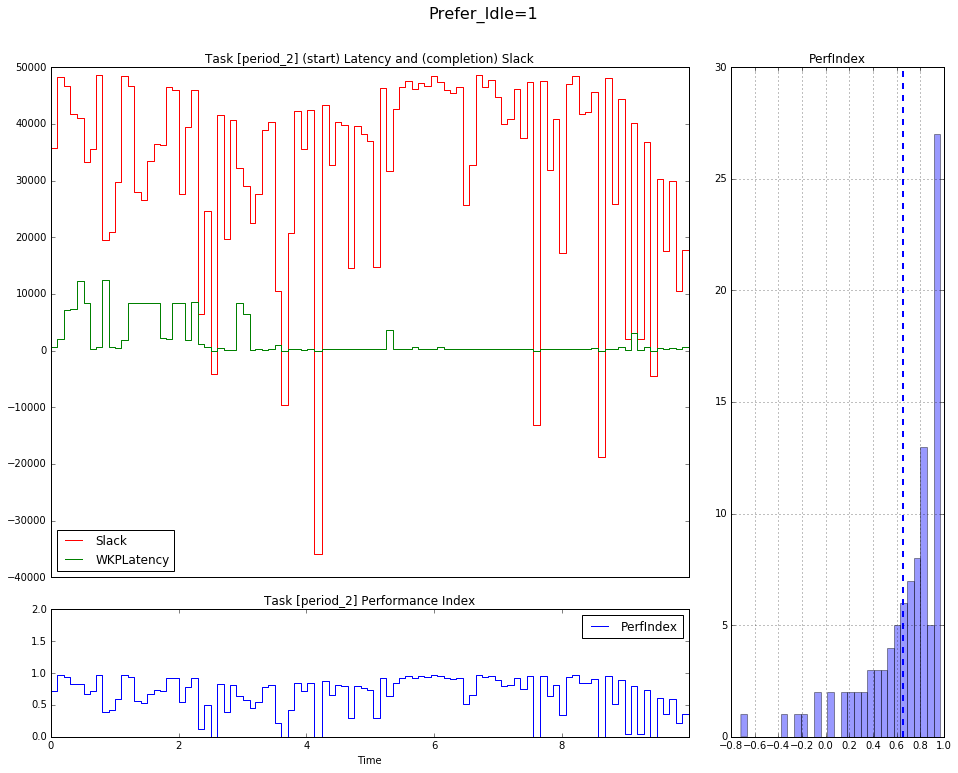

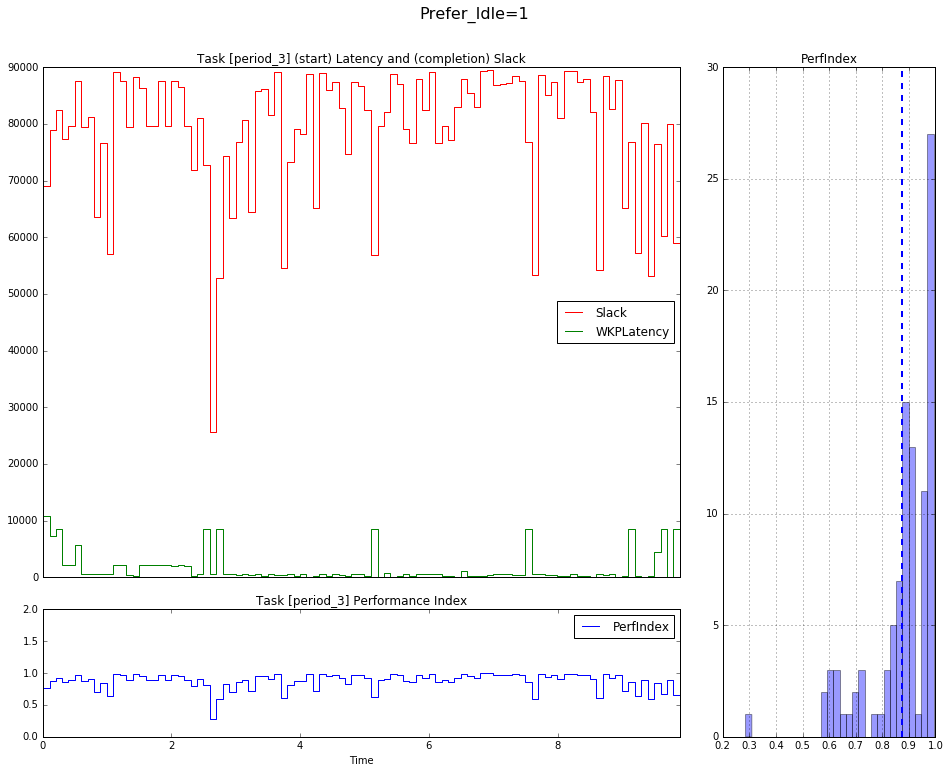

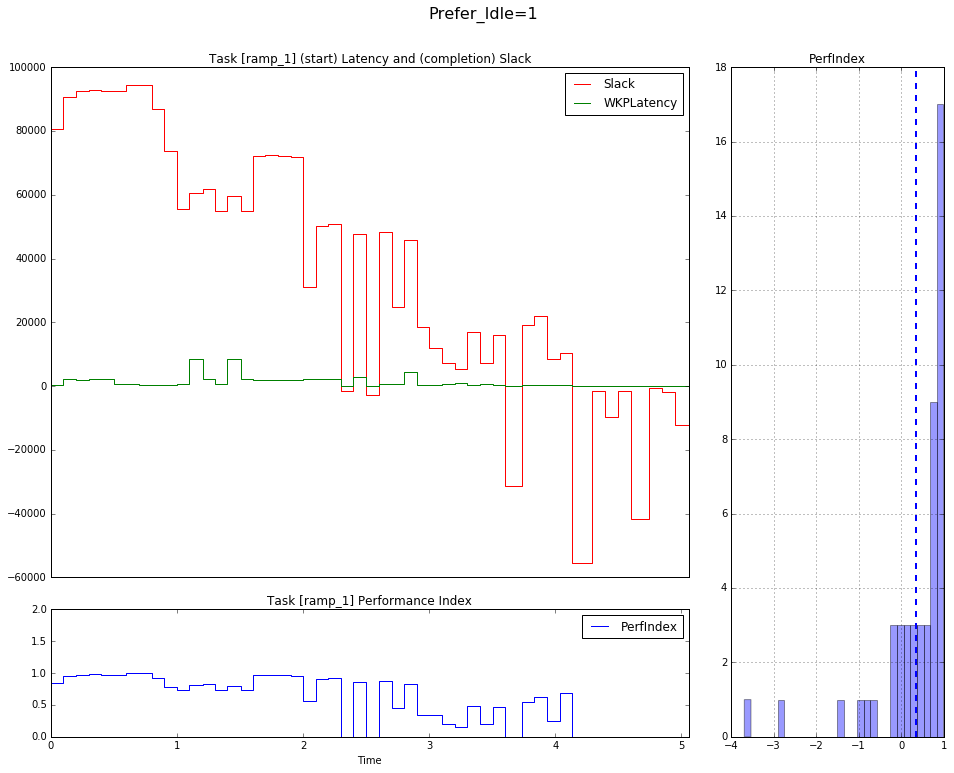

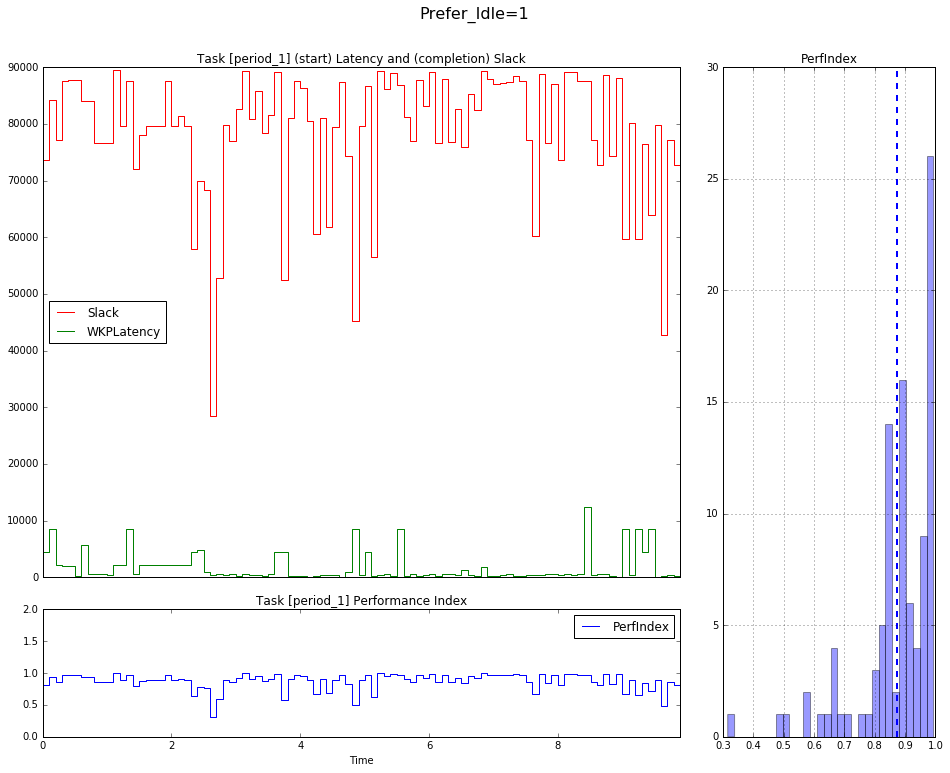

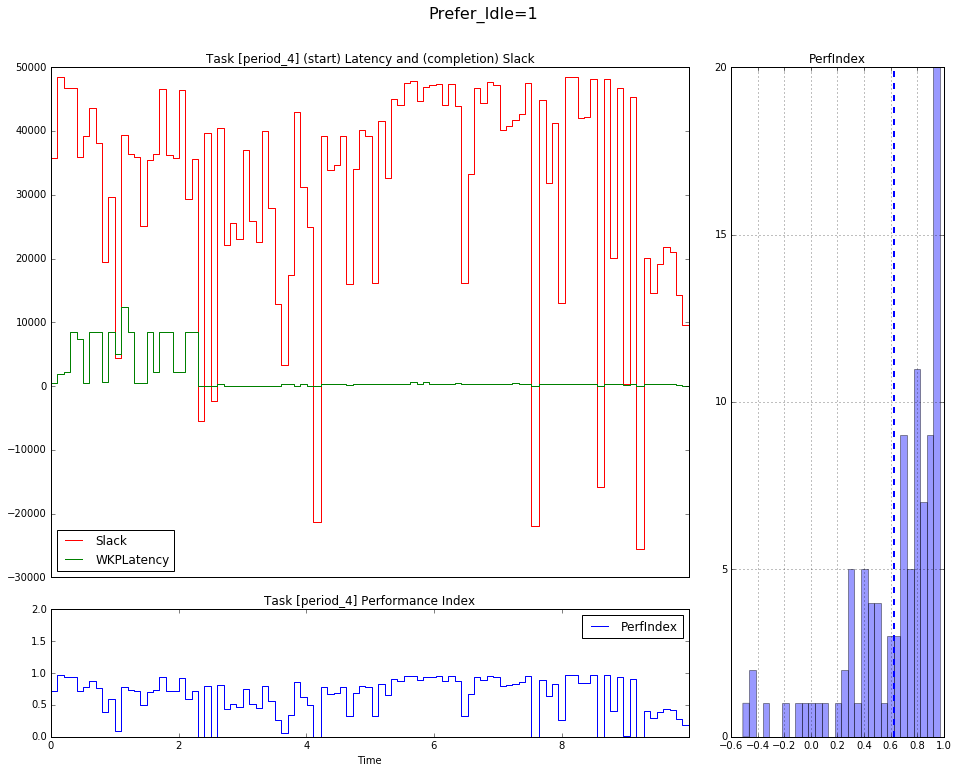

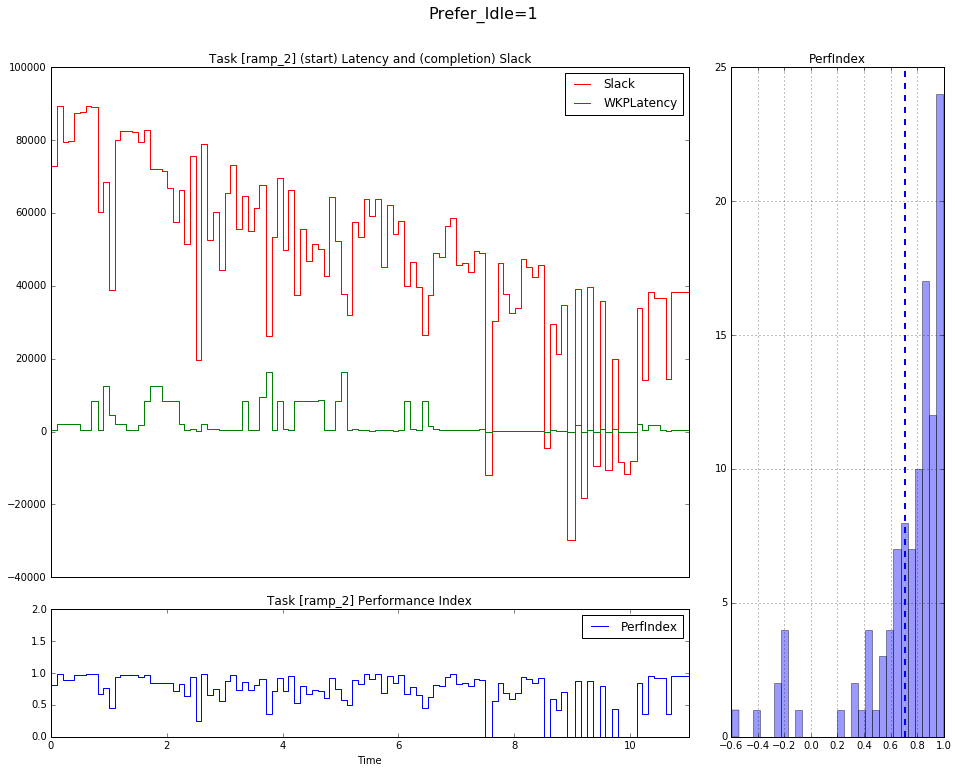

In [31]:
pa_2 = PerfAnalysis( te.res_dir )

for task in pa_2.tasks():
    pa_2.plotPerf(task, "Prefer_Idle=1")